<h1 style = 'font-weight:bold; font-family:Dejavu sans; font-size:50px'>Fɪɴᴇ Tᴜɴɪɴɢ Rᴏʙᴇʀᴛᴀ Fᴏʀ Lᴀɴɢᴜᴀɢᴇ Eɴᴄᴏᴅɪɴɢ</h1>

# Imports


In [1]:
import pandas as pd
from PIL import Image
from collections import defaultdict
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
import json
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from copy import deepcopy
import time
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM
from transformers import RobertaTokenizerFast
from transformers import DataCollatorForLanguageModeling
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import Trainer, TrainingArguments

2024-03-29 05:40:15.215817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 05:40:15.215929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 05:40:15.316117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Setting up device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# creating json file for flickr10k

The files have already been created using the following code 
```python
df = pd.read_csv('/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv', sep='|')
image_list = sorted(list(set(df['image_name'])))
print(f"length of the dataset: {len(image_list)}")


dataset_dict = defaultdict(list)
dataset_dict = defaultdict(list)
for idx, image_id in enumerate(image_list[:10000]):
    filter_df = df[df['image_name']==image_id]
    captions = list()
    for capt in filter_df[' comment']:
        if type(capt)==str:
            capt = f'<s> {capt.strip()[:-2]} <e>'
            captions.append(capt)
        else:
            continue
    dataset_dict[image_id] = deepcopy(captions)

json_string = json.dumps(dataset_dict, indent=4)  
working_dir = "/kaggle/working/"
filename = "flickr10k.json"


file_path = os.path.join(working_dir, filename)
with open(file_path, "w") as f:
    f.write(json_string)
```

# Deleting directories if they exist

In [3]:
def deldir(dir_name):
    dir_path = f'/kaggle/working/{dir_name}'
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        print(f"Directory '{dir_name}' deleted successfully.")
    else:
        print(f"Directory '{dir_name}' not found.")

deldir("text_files")
deldir('wandb')
deldir('RobertaMLM')
deldir('Byte_tokenizer')
    

Directory 'text_files' not found.
Directory 'wandb' not found.
Directory 'RobertaMLM' not found.
Directory 'Byte_tokenizer' not found.


# Importing json file and using it create BPE

## Importing json file and coverting to dataframe

In [4]:
with open('/kaggle/input/flickr-10k/flickr10k.json','r')as f:
    flickr10k = json.loads(f.read())
def findTotalSentence(dataset = flickr10k):
    l = 0
    for elem in dataset.values():l+=len(elem)
    return l
print('total number of sentences being: ',findTotalSentence())

flickr10k_df = pd.DataFrame([])

temp_img = list()
temp_captions = list()
for image,captlist in flickr10k.items():
    for capt in captlist:
        temp_captions.append(capt.replace('<s> ','').replace(' <e>','').strip())
        temp_img.append(f'/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/{image}')
flickr10k_df['image'] = deepcopy(temp_img)
flickr10k_df['captions'] = deepcopy(temp_captions)
print('the dataframe formed being: ')
flickr10k_df[:5]

        

total number of sentences being:  50000
the dataframe formed being: 


,image,captions
0,/kaggle/input/flickr-image-dataset/flickr30k_i...,Two young guys with shaggy hair look at their ...
1,/kaggle/input/flickr-image-dataset/flickr30k_i...,"Two young , White males are outside near many ..."
2,/kaggle/input/flickr-image-dataset/flickr30k_i...,Two men in green shirts are standing in a yard
3,/kaggle/input/flickr-image-dataset/flickr30k_i...,A man in a blue shirt standing in a garden
4,/kaggle/input/flickr-image-dataset/flickr30k_i...,Two friends enjoy time spent together


## making textfiles out of the captions

In [5]:
idx = 0
os.mkdir('text_files')
filter_df = flickr10k_df['captions']
filter_df = filter_df.replace('\n',' ')
for caption in filter_df.to_list():
    with open(f'/kaggle/working/text_files/{idx}.txt','wb') as f:
        f.write(caption.encode('utf-8'))
        idx+=1
        


## Creating BPE tokens

In [6]:
deldir('Byte_tokenizer')
os.mkdir('Byte_tokenizer')
paths = [str(x) for x in Path(".").glob("text_files/*.txt")]
tokenizer = ByteLevelBPETokenizer(lowercase=True)
tokenizer.train(files=paths, vocab_size=20000, min_frequency=2, show_progress=True, special_tokens=["<s>","<pad>","<e>","<unk>","<mask>"])
tokenizer.save_model('Byte_tokenizer')

Directory 'Byte_tokenizer' not found.





['Byte_tokenizer/vocab.json', 'Byte_tokenizer/merges.txt']

In [7]:
with open('/kaggle/working/Byte_tokenizer/vocab.json','r') as f:
    temp = json.loads(f.read())
"vocab_size", len(temp)

('vocab_size', 12329)

# Fine-tuning Language Encoder using Masked Language modeling

## Preparing MLM Dataset and configuring Roberta for it

In [8]:
config = RobertaConfig(
    vocab_size=20000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

model = RobertaForMaskedLM(config=config)
model.to(device)
print('Num parameters: ',model.num_parameters())
tokenizer = RobertaTokenizerFast.from_pretrained('Byte_tokenizer', max_len = 512)

class MLMDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.examples = []
        for example in df.values:
            x=tokenizer(example, max_length = 512, truncation=True, padding=True)
            self.examples += [x.input_ids]
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, i):
        return torch.tensor(self.examples[i])
train_set = MLMDataset(flickr10k_df['captions'][:38000],tokenizer)
val_set = MLMDataset(flickr10k_df['captions'][38000:],tokenizer)

Num parameters:  58896416


In [9]:
l = 0
for i in range(len(train_set)):
    l = max(l,len(train_set[i]))
print(l)

85


In [10]:
len(train_set[1])

16

## Using Datacollator for random masking of tokens during MLM

In [11]:
from transformers import DataCollatorForLanguageModeling

# Define the Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [12]:
data_collator

DataCollatorForLanguageModeling(tokenizer=RobertaTokenizerFast(name_or_path='Byte_tokenizer', vocab_size=12329, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
	12329: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}, mlm=True, mlm_probability=0.15, pad_to_multiple_of=None, t

## Training Roberta MLM Model

In [13]:
training_args = TrainingArguments(
    output_dir= 'RobertaMLM',
    overwrite_output_dir=True,
    evaluation_strategy = 'epoch',
    num_train_epochs=15,
    learning_rate=2e-5,
    weight_decay=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    save_steps=8192,
    save_total_limit=1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_set,
    eval_dataset=val_set,
)

In [14]:
trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch,Training Loss,Validation Loss
1,4.893300,4.851582
2,4.133900,4.126752
3,3.834900,3.752703
4,3.547000,3.506014
5,3.417000,3.330817
6,3.211900,3.257908
7,3.184000,3.161423
8,3.072800,3.122272
9,2.952100,3.041211
10,2.877200,3.006900


TrainOutput(global_step=71250, training_loss=3.3569942896792764, metrics={'train_runtime': 2652.8506, 'train_samples_per_second': 214.863, 'train_steps_per_second': 26.858, 'total_flos': 3573062225806848.0, 'train_loss': 3.3569942896792764, 'epoch': 15.0})

## Checking the preplexity 
$\text{Perplexity = } (\frac{1}{P(s)})^{\frac{1}{n}} \text{ where n is the length of the sentence and P(s) is probability of the sentence found by the product of the probability of each masked model}$

In [15]:
import math
f"Perplexity: {math.exp(trainer.evaluate()['eval_loss']):.2f}"

'Perplexity: 18.36'

## Saving the model

In [16]:
tokenizer.save_pretrained('Byte_tokenizer')
trainer.save_model('RobertaMLM')

## Evaluating Model

In [24]:
from transformers import pipeline
masked_testing = pipeline(
        'fill-mask',
        model = r'RobertaMLM',
        tokenizer = 'Byte_tokenizer'
)

masked_testing('A child in a pink dress is <mask> up a set of stairs in an entry way')

[{'score': 0.13790640234947205,
  'token': 435,
  'token_str': ' holding',
  'sequence': 'A child in a pink dress is holding up a set of stairs in an entry way'},
 {'score': 0.05985509604215622,
  'token': 836,
  'token_str': ' climbing',
  'sequence': 'A child in a pink dress is climbing up a set of stairs in an entry way'},
 {'score': 0.058108482509851456,
  'token': 452,
  'token_str': ' walking',
  'sequence': 'A child in a pink dress is walking up a set of stairs in an entry way'},
 {'score': 0.05070219188928604,
  'token': 565,
  'token_str': ' jumping',
  'sequence': 'A child in a pink dress is jumping up a set of stairs in an entry way'},
 {'score': 0.026804568246006966,
  'token': 505,
  'token_str': ' looking',
  'sequence': 'A child in a pink dress is looking up a set of stairs in an entry way'}]

<h1 style = 'font-weight:bold; font-family:Dejavu sans; font-size:50px'>Fɪɴᴇ-ᴛᴜɴɪɴɢ VɪT Fᴏʀ Iᴍᴀɢᴇ Eɴᴄᴏᴅɪɴɢ</h1>

Here we take the image and convert it into image patches that we pass to the Roberta model and apply cross attention. Thus we get attention matrix. The dimentions of the vectors (or matrices) are shown below considering batch size of 20:
```python
# without considering multiple heads
vit_output = vit(image_patches)
k,v = reshape(vit_output) # 20 x 512 x 768 each
q = RobertaMLM(text) # 20 x 512 x 768
attention = q.matmul(k.T) # 20 x 512 x 512
attended_values = attention.matmul(v) # 20 x 512 x 768
final_values = nn.Linear(768,vocabulary) # 20 x 512 x 12329 as vocab size is 12329
```




# Data Processing

In [32]:
from IPython.display import display
with open('/kaggle/input/flickr-10k/flickr10k.json','r')as f:
    flickr10k = json.loads(f.read())
print('total number of images being: ',len(flickr10k))

# train test splitting
flickr10k_train = dict()
flickr10k_val = dict()
flick = list(flickr10k.items())
train_indices = np.random.choice(np.arange(0, 10000), size=8000, replace=False)
for train_idx in train_indices:
    flickr10k_train[flick[train_idx][0]] = deepcopy(flick[train_idx][1])
for img in flickr10k.keys():
    if img not in flickr10k_train:
        flickr10k_val[img] = deepcopy(flickr10k[img])
        
print(f'length of trainset being: {len(flickr10k_train)} length of validation set being: {len(flickr10k_val)}')   

#converting to dataframes
def convertToDf(dataset):
    df = pd.DataFrame([])
    temp_img = list()
    temp_captions = list()
    for image,captlist in dataset.items():
        for capt in captlist:
            temp_captions.append(capt.replace('<s> ','').replace(' <e>','').strip())
            temp_img.append(f'/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/{image}')
    df['image'] = deepcopy(temp_img)
    df['captions'] = deepcopy(temp_captions)
    return df
flickr10k_train_df = convertToDf(flickr10k_train)
flickr10k_val_df = convertToDf(flickr10k_val)

print('\nVal Set:')
display(flickr10k_val_df.head())
print('Train Set:')
display(flickr10k_train_df.head())


total number of images being:  10000
length of trainset being: 8000 length of validation set being: 2000

Val Set:


,image,captions
0,/kaggle/input/flickr-image-dataset/flickr30k_i...,Several men in hard hats are operating a giant...
1,/kaggle/input/flickr-image-dataset/flickr30k_i...,Workers look down from up above on a piece of ...
2,/kaggle/input/flickr-image-dataset/flickr30k_i...,Two men working on a machine wearing hard hats
3,/kaggle/input/flickr-image-dataset/flickr30k_i...,Four men on top of a tall structure
4,/kaggle/input/flickr-image-dataset/flickr30k_i...,Three men on a large rig


Train Set:


,image,captions
0,/kaggle/input/flickr-image-dataset/flickr30k_i...,There are two boats full of people in a river ...
1,/kaggle/input/flickr-image-dataset/flickr30k_i...,A group of people in two boats with 1 guy in G...
2,/kaggle/input/flickr-image-dataset/flickr30k_i...,The people are riding a gondola down the calm ...
3,/kaggle/input/flickr-image-dataset/flickr30k_i...,Two boats are being maneuvered down a quiet river
4,/kaggle/input/flickr-image-dataset/flickr30k_i...,two boats float down on the riv


# Vision Encoder and tying the Decoder

In [33]:
from transformers import ViTImageProcessor, RobertaTokenizerFast, VisionEncoderDecoderModel, VisionEncoderDecoderConfig
image_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
tokenizer = RobertaTokenizerFast.from_pretrained('/kaggle/input/byte_tokenizer/pytorch/bytetokenizer_flickr10k/1/Byte_tokenizer')

# main model

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained('google/vit-base-patch16-224-in21k',
                                                                  '/kaggle/input/robertamlm/pytorch/mlmtrainedbert/1/RobertaMLM',
                                                                  tie_encoder_decoder=True,
                                                                 )
model.to(device)
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.vocab_size = model.config.decoder.vocab_size
model.config.max_length = 100
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
# model.config.vocab_size

Some weights of RobertaForCausalLM were not initialized from the model checkpoint at /kaggle/input/robertamlm/pytorch/mlmtrainedbert/1/RobertaMLM and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.0.crossattention.output.dense.bias', 'roberta.encoder.layer.0.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossattention.self.key.bias', 'roberta.encoder.layer.0.crossattention.self.key.weight', 'roberta.encoder.layer.0.crossattention.self.query.bias', 'roberta.encoder.layer.0.crossattention.self.query.weight', 'roberta.encoder.layer.0.crossattention.self.value.bias', 'roberta.encoder.layer.0.crossattention.self.value.weight', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.bias', 'roberta.encoder.layer.1.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.1.crossattention.output.dense.bias', 'roberta.encoder.layer.1.crossatte

## Dataset

In [34]:
max_len = max(np.max(flickr10k_train_df['captions'].apply(lambda x : len(x.split()))), np.max(flickr10k_val_df['captions'].apply(lambda x : len(x.split()))))
def findMaxSenLength(captions):
    l = 0
    for capt in captions:
        l = max(l,len(capt.split()))
    return l
max_len = max(findMaxSenLength(flickr10k_train_df['captions']),findMaxSenLength(flickr10k_val_df['captions']))
class CaptioningDataset(Dataset):
    def __init__(self,df,tokenizer = tokenizer, processor = image_processor, max_length = max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.processor = processor
        self.max_length = max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        image, caption = Image.open(self.df['image'][idx]).convert('RGB'), self.df['captions'][idx]
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values
        tokenized_output = self.tokenizer(caption, truncation = True, padding="max_length", max_length=self.max_length)
        lab = tokenized_output.input_ids
        labels = [label if label!=self.tokenizer.pad_token_id else -100 for label in lab]
        attention_mask = tokenized_output.attention_mask
        return {
                'pixel_values':pixel_values.squeeze(),
                'labels':torch.tensor(labels),
                'attention_mask': torch.tensor(attention_mask)
               }
    
train_set = CaptioningDataset(flickr10k_train_df)
val_set = CaptioningDataset(flickr10k_val_df)
        
        
        


# ROUGE Metric
* ROUGE-N measures the number of matching n-grams between the model-generated text and a human-produced reference.
* ROUGE-N precision can be computed as the ratio of the number of n-grams in Candidate that appear also in Reference , over the number of n-grams in Candidate.
* ROUGE-N recall can be computed as the ratio of the number of n-grams in Candidate that appear also in Reference , over the number of n-grams in Reference.
* $ROUGE-N \\ F1-score = 2 \times \frac{(precision \times recall)}{(precision + recall)} $

In [35]:
! pip install rouge_score
import datasets

def compute_metrics(pred):
    rouge = datasets.load_metric('rouge')
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids==-100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [36]:
from transformers import default_data_collator

captioning_model = 'VIT_Captioning'
training_args = Seq2SeqTrainingArguments(
    output_dir=captioning_model,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    predict_with_generate=True,
    fp16=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,  
    save_steps=2048, 
    warmup_steps=1024,  
    num_train_epochs = 3, 
    overwrite_output_dir=True,
    save_total_limit=1,
)


trainer = Seq2SeqTrainer(
    tokenizer=image_processor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_set,
    eval_dataset=val_set,
    data_collator=default_data_collator,
)


In [37]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,3.841900,3.144135,0.098400,0.101600,0.095400
2,2.913700,2.960703,0.119100,0.117400,0.113300
3,2.620600,2.910323,0.114700,0.124500,0.114100


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 100, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.lm_head.decoder.weight', 'decoder.lm_head.decoder.bias'} while saving. This should be

TrainOutput(global_step=6000, training_loss=3.0057042236328124, metrics={'train_runtime': 6589.8632, 'train_samples_per_second': 18.21, 'train_steps_per_second': 0.91, 'total_flos': 1.557569949401088e+19, 'train_loss': 3.0057042236328124, 'epoch': 3.0})

In [38]:
trainer.save_model('ViT_Roberta_Image_Captioning')


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 100, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


The following encoder weights were not tied to the decoder ['vision_encoder_decoder/embeddings', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/embeddings', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm']
The following encoder weights were not tied to the decoder ['vision_encoder_decoder/embeddings', 'vision_encoder_decoder/pooler', 'vision_encoder_decoder/encoder', 'vision_encoder_decoder/layernorm']


caption is: A man in a red shirt and blue jeans is working on a rock


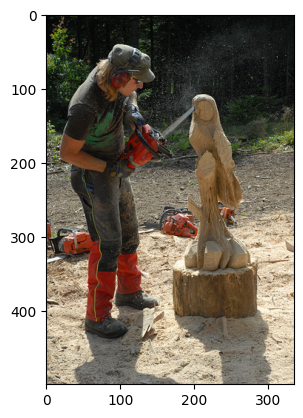

In [49]:
t = VisionEncoderDecoderModel.from_pretrained('/kaggle/working/ViT_Roberta_Image_Captioning')
temp = flickr10k_val_df.sample(1).image.iloc[0]
plt.imshow(Image.open(temp).convert("RGB"))
cap = tokenizer.decode(t.generate(image_processor(Image.open(temp).convert("RGB"), return_tensors="pt").pixel_values)[0])
print(f'caption is: {cap.replace("<s>","").replace("</s>","")}')